Synthetic logistic regression dataset generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.utils import shuffle
import torch

In [2]:
def boundary_u_smooth(x):
    return 0.2 * x**2 - 1

def boundary_u_piecewise_5(x):
    x_breaks = np.array([-4, -2, -1, 1, 2, 4])
    y_breaks = np.array([2, 0.5, -1, -1, 0.5, 2])
    return np.interp(x, x_breaks, y_breaks)

def boundary_sine(x):
    return np.sin(x)

def boundary_gaussian(x):
    return 2 * np.exp(-x**2) - 1

def boundary_abs(x):
    return 0.5 * np.abs(x) - 0.5

def boundary_step(x):
    return np.where(x < 0, -1, 1)

# Predefined 2D region (horseshoe)
def boundary_horseshoe(x1, x2, r_inner=1.5, r_outer=3.0, arc_height=2.0):
    r = np.sqrt(x1**2 + x2**2)
    # Include points exactly on inner and outer radius boundaries (>= and <=)
    return (r >= r_inner) & (r <= r_outer) & (np.abs(x2) <= arc_height)

def boundary_square(x1, x2, x_min=-2, x_max=2, y_min=-2, y_max=2):
    return (x1 >= x_min) & (x1 <= x_max) & (x2 >= y_min) & (x2 <= y_max)


def boundary_circle(x1, x2, center=(0, 0), radius=2):
    r = np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2)
    return r <= radius
    


In [3]:

def generate_continual_dataset(
    n_tasks=6,
    samples_per_task=100,
    x_range=(-5, 5),
    y_range=(-3, 3),
    noise_std=0.4,
    boundary_fn=None,  # function, either f(x1) or f(x1,x2) returning bool/int
    is_2d=False,
    seed=0,
):
    if boundary_fn is None:
        raise ValueError("You must provide a boundary function")

    np.random.seed(seed)
    task_data = []
    all_x, all_y, all_task_ids = [], [], []

    for task_id in range(n_tasks):
        if is_2d:
            X = []
            y = []
            while len(X) < samples_per_task:
                x1 = np.random.uniform(*x_range)
                x2 = np.random.uniform(*y_range)
                label = int(boundary_fn(x1, x2))
                X.append([x1, x2])
                y.append(label)
            X = np.array(X)
            y = np.array(y)
        else:
            x_min, x_max = x_range
            task_width = (x_max - x_min) / n_tasks
            x1_start = x_min + task_id * task_width
            x1_end = x1_start + task_width

            n_per_class = samples_per_task // 2
            x1_vals = np.random.uniform(x1_start, x1_end, size=n_per_class)
            x2_boundary = boundary_fn(x1_vals)
            noise = np.random.normal(0, noise_std, size=n_per_class)

            x0 = np.stack([x1_vals, x2_boundary - np.abs(noise)], axis=1)
            x1 = np.stack([x1_vals, x2_boundary + np.abs(noise)], axis=1)
            X = np.concatenate([x0, x1], axis=0)
            y = np.array([0] * n_per_class + [1] * n_per_class)

        task_data.append((X, y))
        all_x.append(X)
        all_y.append(y)
        all_task_ids.append(np.full(samples_per_task, task_id))

    return task_data, np.concatenate(all_x), np.concatenate(all_y), np.concatenate(all_task_ids)


In [4]:

def plot_sequential_tasks(
    task_data,
    boundary_fn=None,  # function f(x1) for plotting or None to skip
    is_2d=False,
    xlim=(-5, 5),
    ylim=(-3, 3),
    show_boundary=True,
):
    n_tasks = len(task_data)
    n_cols = min(n_tasks, 3)
    n_rows = (n_tasks + n_cols - 1) // n_cols
    cmap = plt.get_cmap("bwr")

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = np.array(axes).reshape(-1)

    x1_vals = np.linspace(*xlim, 300)

    x2_vals = None
    if boundary_fn is not None and not is_2d and show_boundary:
        x2_vals = boundary_fn(x1_vals)

    all_prev_X, all_prev_y = [], []

    for i, (X, y) in enumerate(task_data):
        ax = axes[i]

        if all_prev_X:
            prev_X = np.concatenate(all_prev_X)
            prev_y = np.concatenate(all_prev_y)
            ax.scatter(
                prev_X[:, 0],
                prev_X[:, 1],
                c=prev_y,
                cmap=cmap,
                alpha=0.15,
                edgecolor="none",
                s=20,
                label="Past",
            )

        ax.scatter(
            X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolor="k", s=30, alpha=0.8, label="Current Task"
        )

        if x2_vals is not None:
            ax.plot(x1_vals, x2_vals, "k--", label="Boundary")

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_title(f"Task {i}")
        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")
        ax.grid(True)
        ax.legend(loc="upper right")

        all_prev_X.append(X)
        all_prev_y.append(y)

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

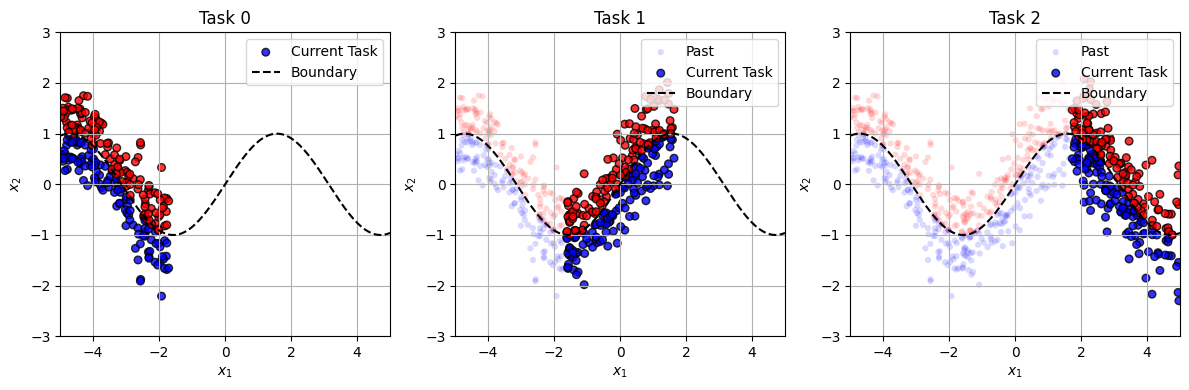

In [7]:
b = boundary_sine

task_data, all_x, all_y, all_task_ids = generate_continual_dataset(
    boundary_fn=b,
    is_2d=False,
    seed=42, 
    n_tasks=3,
    samples_per_task=250,
    noise_std=0.5
)

plot_sequential_tasks(task_data, boundary_fn=b, is_2d=False)


In [8]:

def save_dataset(filename, all_x, all_y, all_task_ids):
    np.savez(filename, X=all_x, y=all_y, task_ids=all_task_ids)


In [10]:

save_dataset("../datasets/synthetic/sine_dataset_3.npz", all_x, all_y, all_task_ids)


In [8]:
import torch
from torch.utils.data import Dataset

class ContinualLogisticDataset(Dataset):
    def __init__(self, npz_file, transform=None):
        data = np.load(npz_file)
        self.X = data["X"].astype(np.float32)
        self.y = data["y"].astype(np.int64)
        self.task_ids = data["task_ids"].astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        task = self.task_ids[idx]
        if self.transform:
            x = self.transform(x)
        return {"x": torch.from_numpy(x), "y": torch.tensor(y), "task": torch.tensor(task)}


In [12]:
from torch.utils.data import DataLoader

dataset = ContinualLogisticDataset("datasets/synthetic/smoothu_dataset_3.npz")
loader = DataLoader(dataset, batch_size=64, shuffle=True)

for batch in loader:
    x = batch["x"]       # shape: [batch_size, 2]
    y = batch["y"]       # shape: [batch_size]
    task = batch["task"] # shape: [batch_size]

In [13]:
len(dataset)

750